# Задача 1

In [486]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sps
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

$Q(w) = \sum\limits_{i=1}^{m}\log{(1 + \exp(-y_i <x_i, w>))}$

$\nabla Q(w) = -\sum\limits_{i=1}^{m}\frac{x_i y_i \exp(-y_i  <x_i, w>)}{1 + \exp(-y_i  <x_i, w>)}$ ($x_i$ стоит трактовать как вектор, таким образом получим вектор градиентов)

Модель поддерживает шаги:

* Постоянный - параметр learning rate
* Зависящий от номера шага - параметр iter_func
* Правило одномерной минимизации (так как фугкция выпукла, то корректно перебирать тернарным поиском)

In [161]:
class LogisticRegression:
    def __init__(self):
        self.params = None
        self.cur_iter = 0
    
    def fit(self, X, y, threshold=1e-3, max_iter=100, seed=None, iter_func=None, lr=0.01, 
            use_one_side_minimization=False, top_fastest_one_side_border=0.1, top_fastest_one_side_max_steps=10):
        cur_error = None
        self.params = sps.norm().rvs(X.shape[1])
        if seed is not None:
            self.params = seed
        prev_params = None
        while self.cur_iter < max_iter:
            preds = self._predict_degree(X, self.params)
            cur_error = self._loss(preds, y)
            if  cur_error < threshold:
                break
            prev_error = cur_error
            gradient = self._gradient(X, preds, y)
            if  use_one_side_minimization:
                gradient *= self._calculate_fastest_one_side(X, y, gradient, top_fastest_one_side_border, 
                                                             threshold, top_fastest_one_side_max_steps)
            elif iter_func is not None:
                gradient *= iter_func(self.cur_iter)
            else:
                gradient *= lr
            self.params -= gradient
            self.cur_iter += 1
        
    def predict(self, X):
        return 1 / (1 + np.exp(-X @ self.params))
        
    def _loss(self, preds, y):
        return np.log(1 + np.exp(-y * preds)).sum()
    
    def _gradient(self, X, preds, y):
        margin = (y * preds)[:, np.newaxis]
        return -(X * y[:, np.newaxis] * np.exp(-margin) / (1 + np.exp(-margin))).sum(0)
    
    def _predict_degree(self, X, params):
        return X @ params
    
    def _calculate_fastest_one_side(self, X, y, gradient, top_fastest_one_side_border, threshold, 
                                    top_fastest_one_side_max_steps):
        left_border = 0
        right_border = top_fastest_one_side_border
        cur_iter = 0
        while cur_iter < top_fastest_one_side_max_steps and right_border - left_border > threshold:
            a = (left_border * 2 + right_border) / 3
            b = (left_border + right_border * 2) / 3
            if self._loss(self._predict_degree(X, self.params - left_border * gradient), y) <\
               self._loss(self._predict_degree(X, self.params - left_border * gradient), y):
                right_border = b
            else:
                left_border = a
            cur_iter += 1
        return (left_border + right_border) / 2

## Посмотрим на работу алгоритма на практике

In [162]:
def generate_data(sample_size=100, dim=2, separable=True):
    X = np.concatenate((-np.ones((sample_size, 1)), sps.uniform(loc=-5, scale=10).rvs((sample_size, dim))), -1)
    if separable:
        hyperplane = sps.uniform(loc=-0.5, scale=1).rvs(dim)
        y = (X[:, 1:] @ hyperplane >= 0).astype(np.int64)
        y[y == 0] = -1
        return X, y, hyperplane
    y = sps.randint(low=0, high=2).rvs(sample_size)
    y[y == 0] = -1
    return X, y

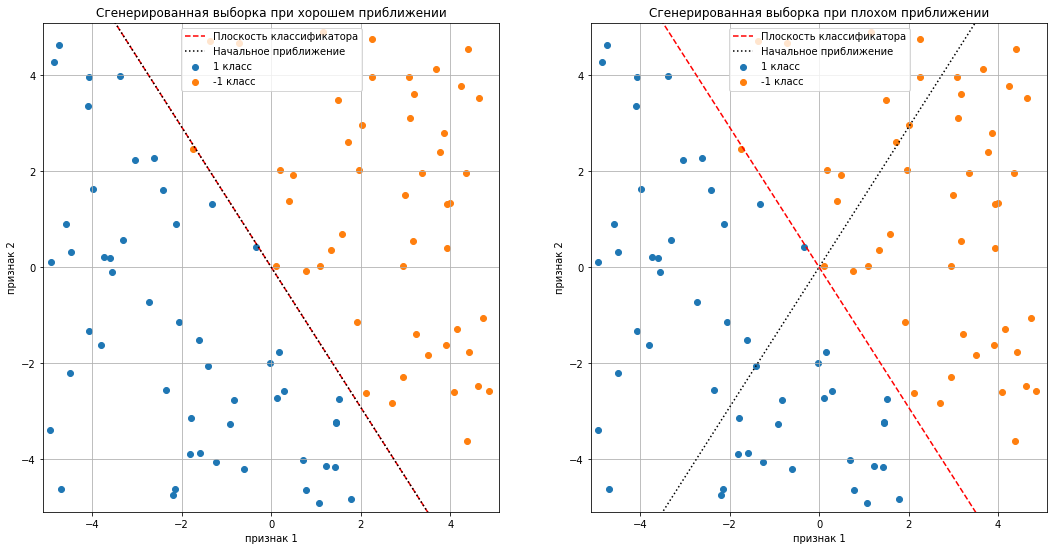

In [163]:
X, y, plane = generate_data()
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 9))
for i, ax in enumerate(axs):
    seed = np.array([0.0] + list(plane))
    
    seed_multiplier = 1
    if i == 1:
        seed_multiplier = -1
        seed[-1] = -seed[-1]
    
    classifier = LogisticRegression()
    classifier.fit(X, y, seed=seed)

    grid = np.linspace(-5, 5, 100)
    positive_mask = (y == 1)
    
    ax.scatter(X[positive_mask, 1], X[positive_mask, 2], label='1 класс')
    ax.scatter(X[~positive_mask, 1], X[~positive_mask, 2], label='-1 класс')
    ax.plot(grid, -classifier.params[1] / classifier.params[2] * grid, label='Плоскость классификатора',
             c='r', ls='dashed')
    ax.plot(grid, -seed_multiplier * seed[-2] / seed[-1] * grid, label='Начальное приближение', c='black', ls='dotted')
    ax.legend()
    ax.set_xlim(-5.1, 5.1)
    ax.set_ylim(-5.1, 5.1)
    ax.set_xlabel('признак 1')
    ax.set_ylabel('признак 2')
    ax.set_title('Сгенерированная выборка при {} приближении'.format("плохом" if i == 1 else "хорошем"))
    ax.grid()

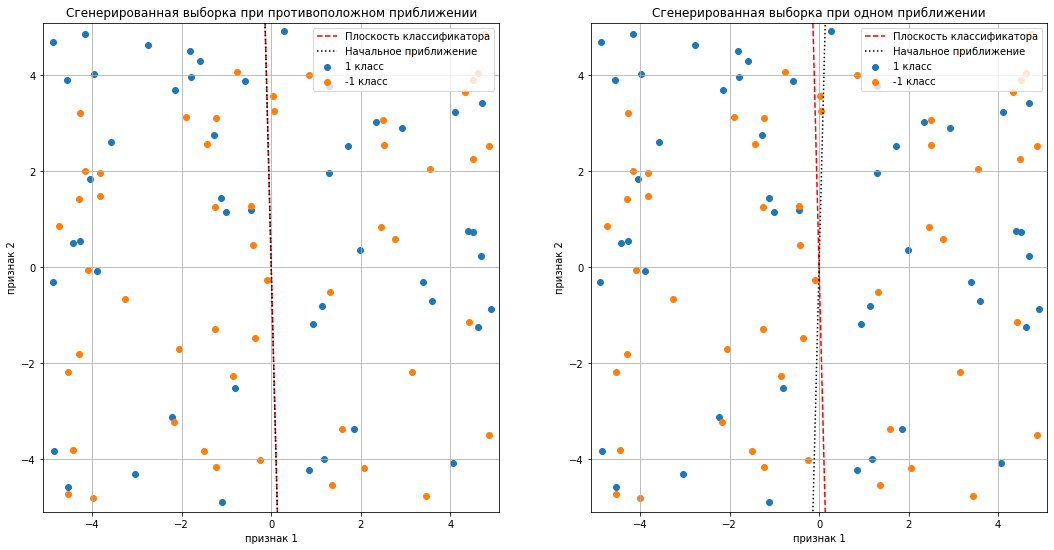

In [164]:
X, y = generate_data(separable=False)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 9))
for i, ax in enumerate(axs):
    seed = np.array([0.0, 1.0, 2.0])
    
    seed_multiplier = 1
    if i == 1:
        seed_multiplier = -1
        seed[-1] = -seed[-1]
    
    classifier = LogisticRegression()
    classifier.fit(X, y, seed=seed)

    grid = np.linspace(-5, 5, 100)
    positive_mask = (y == 1)
    
    ax.scatter(X[positive_mask, 1], X[positive_mask, 2], label='1 класс')
    ax.scatter(X[~positive_mask, 1], X[~positive_mask, 2], label='-1 класс')
    ax.plot(grid, -classifier.params[1] / classifier.params[2] * grid, label='Плоскость классификатора',
             c='r', ls='dashed')
    ax.plot(grid, -seed_multiplier * seed[-2] / seed[-1] * grid, label='Начальное приближение', c='black', ls='dotted')
    ax.legend()
    ax.set_xlim(-5.1, 5.1)
    ax.set_ylim(-5.1, 5.1)
    ax.set_xlabel('признак 1')
    ax.set_ylabel('признак 2')
    ax.set_title('Сгенерированная выборка при {} приближении'.format("одном" if i == 1 else "противоположном"))
    ax.grid()

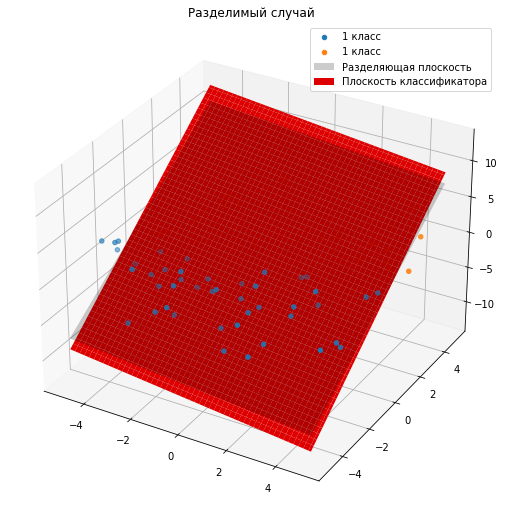

In [172]:
X, y, plane = generate_data(dim=3)
classifier = LogisticRegression()
classifier.fit(X, y, seed=np.array([0] + list(plane)))

fig = plt.figure(figsize=(16, 9))
ax = fig.gca(projection='3d')
ax.scatter(X[y == 1, 1], X[y == 1, 2], X[y == 1, 3], label='1 класс')
ax.scatter(X[y == -1, 1], X[y == -1, 2], X[y == -1, 3], label='1 класс')

xgrid, ygrid = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
zgrid = (xgrid * plane[0] + ygrid * plane[1]) / plane[2]

params = classifier.params
classifier_zgrid = (xgrid * params[1] + ygrid * params[2]) / params[3]

surf = ax.plot_surface(xgrid, ygrid, zgrid, alpha=0.2, label='Разделяющая плоскость', color='black')
surf._facecolors2d=surf._facecolors3d
surf._edgecolors2d=surf._edgecolors3d

surf = ax.plot_surface(xgrid, ygrid, classifier_zgrid, label='Плоскость классификатора', color='r')
surf._facecolors2d=surf._facecolors3d
surf._edgecolors2d=surf._edgecolors3d
plt.title('Разделимый случай')
plt.legend()
plt.show()

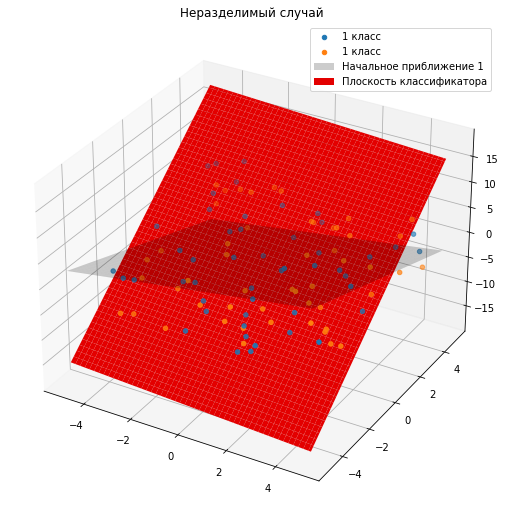

In [168]:
X, y = generate_data(dim=3, separable=False)
classifier = LogisticRegression()
classifier.fit(X, y, seed=np.array([0] + list(plane)))

fig = plt.figure(figsize=(16, 9))
ax = fig.gca(projection='3d')
ax.scatter(X[y == 1, 1], X[y == 1, 2], X[y == 1, 3], label='1 класс')
ax.scatter(X[y == -1, 1], X[y == -1, 2], X[y == -1, 3], label='1 класс')

xgrid, ygrid = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
zgrid = (xgrid * plane[0] + ygrid * plane[1]) / plane[2]

params = classifier.params
classifier_zgrid = (xgrid * params[1] + ygrid * params[2]) / params[3]

surf = ax.plot_surface(xgrid, ygrid, zgrid, alpha=0.2, label='Начальное приближение 1', color='black')
surf._facecolors2d=surf._facecolors3d
surf._edgecolors2d=surf._edgecolors3d

surf = ax.plot_surface(xgrid, ygrid, classifier_zgrid, label='Плоскость классификатора', color='r')
surf._facecolors2d=surf._facecolors3d
surf._edgecolors2d=surf._edgecolors3d
plt.legend()
plt.title('Неразделимый случай')
plt.show()

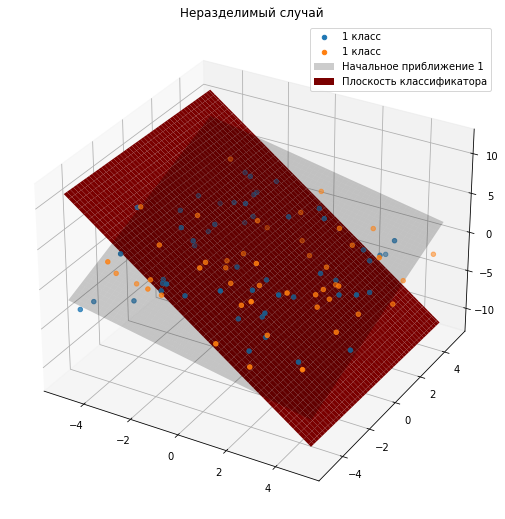

In [40]:
plane[0] *= -1
classifier = LogisticRegression()
classifier.fit(X, y, seed=np.array([0] + list(plane)))

fig = plt.figure(figsize=(16, 9))
ax = fig.gca(projection='3d')
ax.scatter(X[y == 1, 1], X[y == 1, 2], X[y == 1, 3], label='1 класс')
ax.scatter(X[y == -1, 1], X[y == -1, 2], X[y == -1, 3], label='1 класс')

xgrid, ygrid = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
zgrid = (xgrid * plane[0] + ygrid * plane[1]) / plane[2]

params = classifier.params
classifier_zgrid = (xgrid * params[1] + ygrid * params[2]) / params[3]

surf = ax.plot_surface(xgrid, ygrid, zgrid, alpha=0.2, label='Начальное приближение 1', color='black')
surf._facecolors2d=surf._facecolors3d
surf._edgecolors2d=surf._edgecolors3d

surf = ax.plot_surface(xgrid, ygrid, classifier_zgrid, label='Плоскость классификатора', color='r')
surf._facecolors2d=surf._facecolors3d
surf._edgecolors2d=surf._edgecolors3d
plt.legend()
plt.title('Неразделимый случай')
plt.show()

**Вывод:** алгоритм работает, прекрасно разделяя классы между собой, если они разделимы. В обеих случаях если выборки линейно разделимы, то начальное приближение большой роли не играет, но если неразделимы, то ответы могут меняться в зависимости от приближения

## Посмотрим на скорость сходимости алгоритмов

In [7]:
def train_and_get_iter_cnt(X, y, epsillon, **kwargs):
    # для того, чтобы приближения были одинаковы каждый раз
    np.random.seed(seed=42)
    classifier = LogisticRegression()
    classifier.fit(X, y, max_iter=float('inf'), threshold=epsillon, **kwargs)
    return classifier.cur_iter

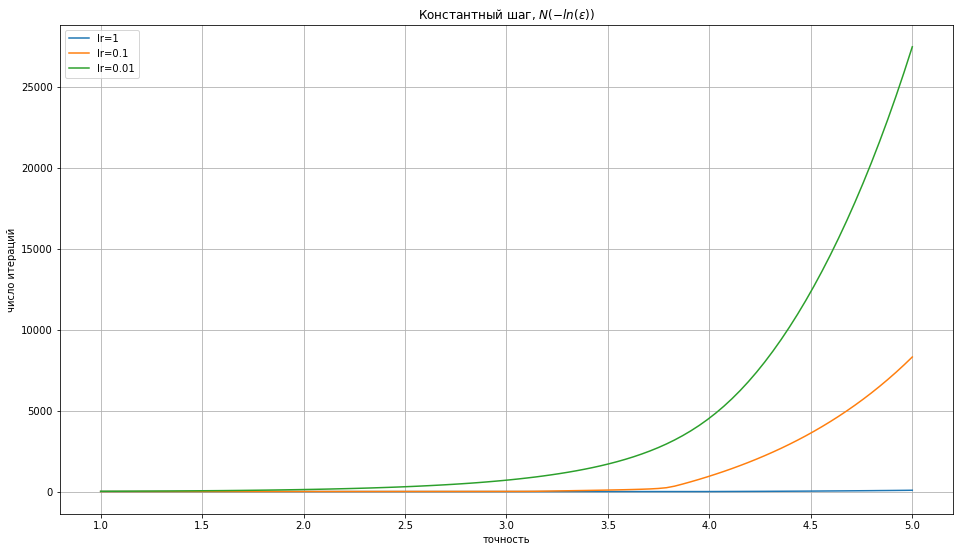

In [44]:
plt.figure(figsize=(16, 9))
X, y, plane = generate_data()
epsillon_grid = 10 ** -np.linspace(1, 5, 100)

lr_filler = lambda epsillon: train_and_get_iter_cnt(X, y, epsillon, lr=1)
iters1 = [lr_filler(eps) for eps in epsillon_grid]
plt.plot(-np.log(epsillon_grid) / np.log(10), iters1, label='lr=1')

lr_filler = lambda epsillon: train_and_get_iter_cnt(X, y, epsillon, lr=0.1)
iters01 = [lr_filler(eps) for eps in epsillon_grid]
plt.plot(-np.log(epsillon_grid) / np.log(10), iters01, label='lr=0.1')

lr_filler = lambda epsillon: train_and_get_iter_cnt(X, y, epsillon, lr=0.01)
iters001 = [lr_filler(eps) for eps in epsillon_grid]
plt.plot(-np.log(epsillon_grid) / np.log(10), iters001, label='lr=0.01')
plt.grid()
plt.title('Константный шаг, $N(-ln(\epsilon))$')
plt.legend()
plt.xlabel('точность')
plt.ylabel('число итераций')
plt.show()

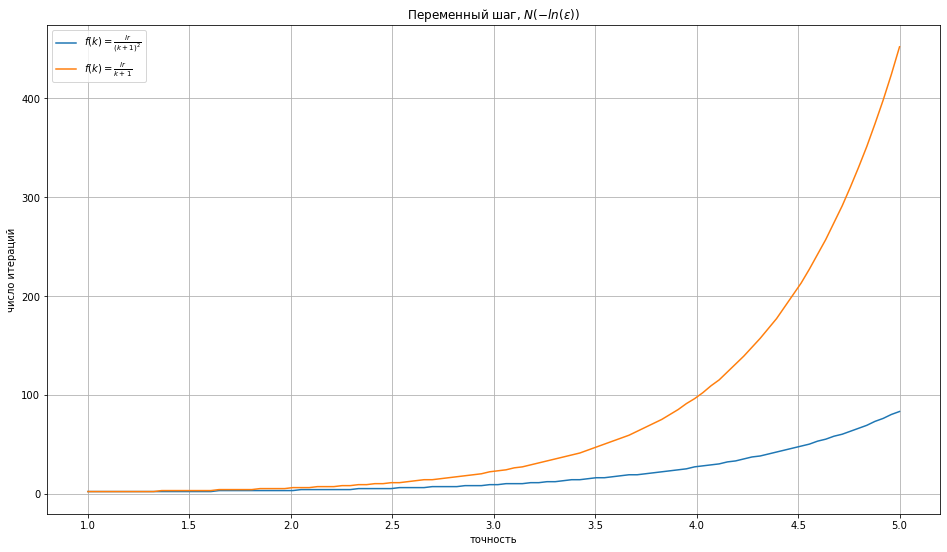

In [47]:
plt.figure(figsize=(16, 9))
lr_filler = lambda epsillon: train_and_get_iter_cnt(X, y, epsillon, iter_func=lambda k: 0.1/(k+1)**2)
iters_sqr = [lr_filler(eps) for eps in epsillon_grid]
plt.plot(-np.log(epsillon_grid) / np.log(10), iters_sqr, label=r'$f(k)=\frac{lr}{(k+1)^2}$')
lr_filler = lambda epsillon: train_and_get_iter_cnt(X, y, epsillon, iter_func=lambda k: 0.1/(k+1))
iters = [lr_filler(eps) for eps in epsillon_grid]
plt.plot(-np.log(epsillon_grid) / np.log(10), iters, label=r'$f(k)=\frac{lr}{k+1}$')
plt.grid()
plt.title('Переменный шаг, $N(-ln(\epsilon))$')
plt.xlabel('точность')
plt.ylabel('число итераций')
plt.legend()
plt.show()

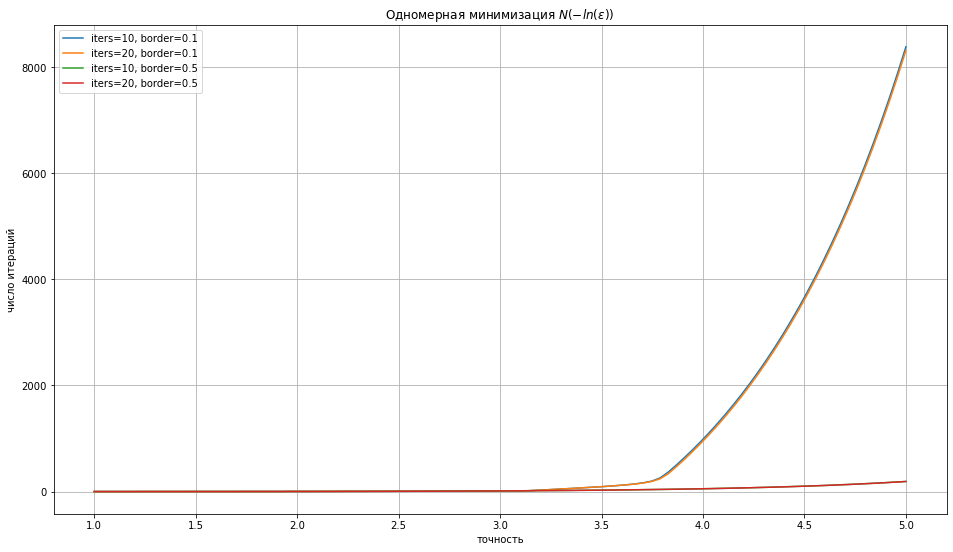

In [46]:
plt.figure(figsize=(16, 9))
lr_filler = lambda epsillon: train_and_get_iter_cnt(X, y, epsillon, use_one_side_minimization=True)
iters = [lr_filler(eps) for eps in epsillon_grid]
plt.plot(-np.log(epsillon_grid) / np.log(10), iters, label=r'iters=10, border=0.1')
lr_filler = lambda epsillon: train_and_get_iter_cnt(X, y, epsillon, use_one_side_minimization=True,
                                                    top_fastest_one_side_max_steps=20)
iters = [lr_filler(eps) for eps in epsillon_grid]
plt.plot(-np.log(epsillon_grid) / np.log(10), iters, label=r'iters=20, border=0.1')
lr_filler = lambda epsillon: train_and_get_iter_cnt(X, y, epsillon, use_one_side_minimization=True,
                                                    top_fastest_one_side_max_steps=10, top_fastest_one_side_border=0.5)
iters = [lr_filler(eps) for eps in epsillon_grid]
plt.plot(-np.log(epsillon_grid) / np.log(10), iters, label=r'iters=10, border=0.5')
lr_filler = lambda epsillon: train_and_get_iter_cnt(X, y, epsillon, use_one_side_minimization=True,
                                                    top_fastest_one_side_max_steps=20, top_fastest_one_side_border=0.5)
iters = [lr_filler(eps) for eps in epsillon_grid]
plt.plot(-np.log(epsillon_grid) / np.log(10), iters, label=r'iters=20, border=0.5')
plt.grid()
plt.title('Одномерная минимизация $N(-ln(\epsilon))$')
plt.xlabel('точность')
plt.ylabel('число итераций')
plt.legend()
plt.show()

**Вывод:** видим, что в случае с нашей задачей увеличение learning rate (до рассмотренного значения) приводит к увеличению скорости сходимости метода. Метод с перемнным шагом работает быстрее константного с тем же learning rate, это происходит потому что с увеличением необходимой точности, как правило, нужно вносить меньшие значения в параметры и уменьшенный размер шага помогает в этом. Метод одномерной минимизации работает заметно лучше метода с аналогичным lr.

## Метод Ньютона-Рафсона

Метод помогает итеративно искать нули функции. Из-за выпуклости исходной функции его можем использовать для поиска нуля градиента => минимума функции ошибки

$x_{k+1} = x_k - (\nabla \nabla Q(w))^{-1} \nabla Q(w)$, где 

$\nabla Q(w) = -\sum\limits_{i=1}^{m}\frac{x_i y_i \exp(-y_i  <x_i, w>}{1 + \exp(-y_i  <x_i, w>)} = -\sum\limits_{i=1}^{m}(x_i y_i \exp(-y_i  <x_i, w>)\sigma(y_i  <x_i, w>)$

$\frac{\partial Q(w)}{\partial w_j \partial w_k} = \sum\limits_{i=1}^{m}(y_i^2x_{i,k}x_{i,j}\exp(-y_i  <x_i, w>))\sigma^2(y_i  <x_i, w>)$

In [ ]:
class NewtonRaphson:
    def __init__(self):
        self.params = None
        self.cur_iter = 0
    
    def fit(self, X, y, threshold=1e-3, max_iter=100, seed=None, iter_func=None, lr=0.01, 
            use_one_side_minimization=False, top_fastest_one_side_border=0.1, top_fastest_one_side_max_steps=10,
            max_grad=100):
        self.params = sps.norm().rvs(X.shape[1])
        if seed is not None:
            self.params = seed
        while self.cur_iter < max_iter:
            preds = self._predict_degree(X, self.params)
            cur_error = self._loss(preds, y)
            if abs(cur_error) < threshold:
                break
            prev_error = cur_error
            gradient = self._gradient(X, preds, y)
            if  use_one_side_minimization:
                gradient *= self._calculate_fastest_one_side(X, y, gradient, top_fastest_one_side_border, 
                                                             threshold, top_fastest_one_side_max_steps)
            elif iter_func is not None:
                gradient *= iter_func(self.cur_iter)
            else:
                gradient *= lr
            self.params -= gradient
            self.cur_iter += 1
        
    def predict(self, X):
        return 1 / (1 + np.exp(-X @ self.params))
        
    def _loss(self, preds, y):
        return np.log(1 + np.exp(-y * preds)).sum()
    
    def _gradient(self, X, preds, y):
        new_X = np.array([X] * len(self.params)).transpose(2, 0, 1) * X.T.reshape(1, len(self.params), len(X))
        margin = (y * preds)
        sigmoid = 1 / (1 + np.exp(-margin))
        second_derivative = np.einsum('ijk,k->ij', new_X, y**2 * np.exp(-margin) * sigmoid**2)
        margin = margin[:, np.newaxis]
        first_detivative = -(y[:, np.newaxis] * X * np.exp(-margin) / (1 + np.exp(-margin))).sum(0)
        return np.linalg.inv(second_derivative) @ first_detivative
        
    def _predict_degree(self, X, params):
        return X @ params
    
    def _calculate_fastest_one_side(self, X, y, gradient, top_fastest_one_side_border, threshold, 
                                    top_fastest_one_side_max_steps):
        left_border = 0
        right_border = top_fastest_one_side_border
        cur_iter = 0
        while cur_iter < top_fastest_one_side_max_steps and right_border - left_border > threshold:
            a = (left_border * 2 + right_border) / 3
            b = (left_border + right_border * 2) / 3
            if self._loss(self._predict_degree(X, self.params - left_border * gradient), y) <\
               self._loss(self._predict_degree(X, self.params - left_border * gradient), y):
                right_border = b
            else:
                left_border = a
            cur_iter += 1
        return (left_border + right_border) / 2

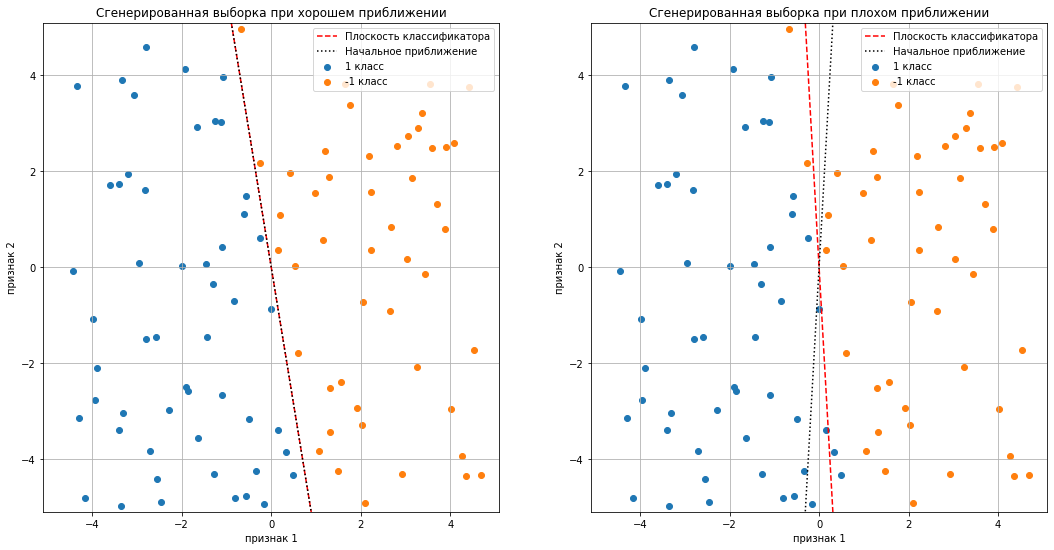

In [192]:
X, y, plane = generate_data()
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 9))
for i, ax in enumerate(axs):
    seed = np.array([0.0] + list(plane))
    
    seed_multiplier = 1
    if i == 1:
        seed_multiplier = -1
        seed[-1] = -seed[-1]
    
    classifier = NewtonRaphson()
    classifier.fit(X, y, seed=seed)

    grid = np.linspace(-5, 5, 100)
    positive_mask = (y == 1)
    
    ax.scatter(X[positive_mask, 1], X[positive_mask, 2], label='1 класс')
    ax.scatter(X[~positive_mask, 1], X[~positive_mask, 2], label='-1 класс')
    ax.plot(grid, -classifier.params[1] / classifier.params[2] * grid, label='Плоскость классификатора',
             c='r', ls='dashed')
    ax.plot(grid, -seed_multiplier * seed[-2] / seed[-1] * grid, label='Начальное приближение', c='black', ls='dotted')
    ax.legend()
    ax.set_xlim(-5.1, 5.1)
    ax.set_ylim(-5.1, 5.1)
    ax.set_xlabel('признак 1')
    ax.set_ylabel('признак 2')
    ax.set_title('Сгенерированная выборка при {} приближении'.format("плохом" if i == 1 else "хорошем"))
    ax.grid()

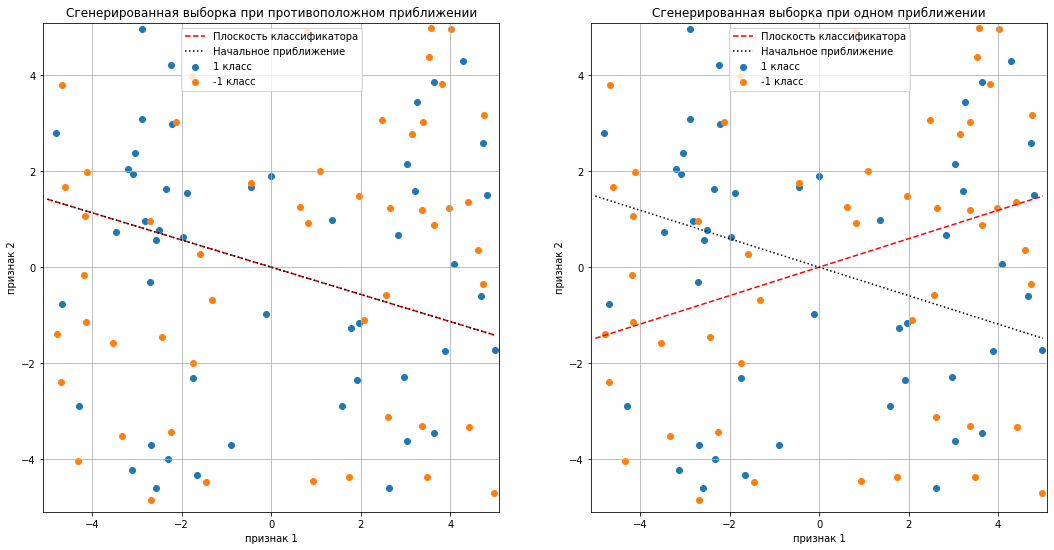

In [193]:
X, y = generate_data(separable=False)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 9))
for i, ax in enumerate(axs):
    seed = np.array([0.0, 1.0, 2.0])
    
    seed_multiplier = 1
    if i == 1:
        seed_multiplier = -1
        seed[-1] = -seed[-1]
    
    classifier = NewtonRaphson()
    classifier.fit(X, y, seed=seed)

    grid = np.linspace(-5, 5, 100)
    positive_mask = (y == 1)
    
    ax.scatter(X[positive_mask, 1], X[positive_mask, 2], label='1 класс')
    ax.scatter(X[~positive_mask, 1], X[~positive_mask, 2], label='-1 класс')
    ax.plot(grid, -classifier.params[1] / classifier.params[2] * grid, label='Плоскость классификатора',
             c='r', ls='dashed')
    ax.plot(grid, -seed_multiplier * seed[-2] / seed[-1] * grid, label='Начальное приближение', c='black', ls='dotted')
    ax.legend()
    ax.set_xlim(-5.1, 5.1)
    ax.set_ylim(-5.1, 5.1)
    ax.set_xlabel('признак 1')
    ax.set_ylabel('признак 2')
    ax.set_title('Сгенерированная выборка при {} приближении'.format("одном" if i == 1 else "противоположном"))
    ax.grid()

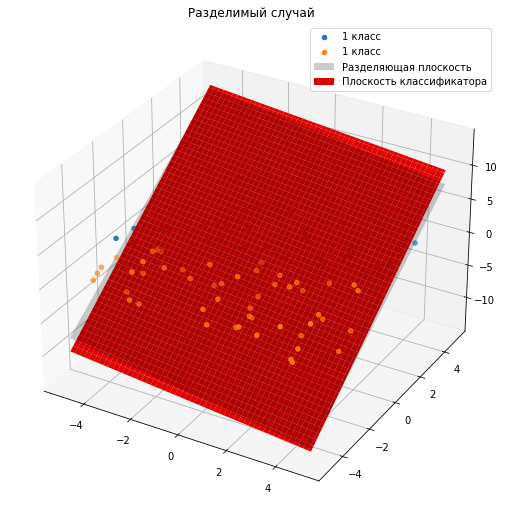

In [195]:
X, y, plane = generate_data(dim=3)
classifier = NewtonRaphson()
classifier.fit(X, y, seed=np.array([0] + list(plane)))

fig = plt.figure(figsize=(16, 9))
ax = fig.gca(projection='3d')
ax.scatter(X[y == 1, 1], X[y == 1, 2], X[y == 1, 3], label='1 класс')
ax.scatter(X[y == -1, 1], X[y == -1, 2], X[y == -1, 3], label='1 класс')

xgrid, ygrid = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
zgrid = (xgrid * plane[0] + ygrid * plane[1]) / plane[2]

params = classifier.params
classifier_zgrid = (xgrid * params[1] + ygrid * params[2]) / params[3]

surf = ax.plot_surface(xgrid, ygrid, zgrid, alpha=0.2, label='Разделяющая плоскость', color='black')
surf._facecolors2d=surf._facecolors3d
surf._edgecolors2d=surf._edgecolors3d

surf = ax.plot_surface(xgrid, ygrid, classifier_zgrid, label='Плоскость классификатора', color='r')
surf._facecolors2d=surf._facecolors3d
surf._edgecolors2d=surf._edgecolors3d
plt.title('Разделимый случай')
plt.legend()
plt.show()

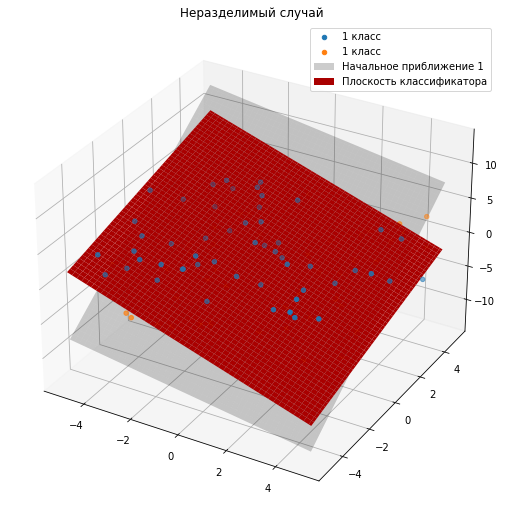

In [199]:
X, y = generate_data(dim=3, separable=False)
classifier = NewtonRaphson()
classifier.fit(X, y, seed=np.array([0] + list(plane)))

fig = plt.figure(figsize=(16, 9))
ax = fig.gca(projection='3d')
ax.scatter(X[y == 1, 1], X[y == 1, 2], X[y == 1, 3], label='1 класс')
ax.scatter(X[y == -1, 1], X[y == -1, 2], X[y == -1, 3], label='1 класс')

xgrid, ygrid = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
zgrid = (xgrid * plane[0] + ygrid * plane[1]) / plane[2]

params = classifier.params
classifier_zgrid = (xgrid * params[1] + ygrid * params[2]) / params[3]

surf = ax.plot_surface(xgrid, ygrid, zgrid, alpha=0.2, label='Начальное приближение 1', color='black')
surf._facecolors2d=surf._facecolors3d
surf._edgecolors2d=surf._edgecolors3d

surf = ax.plot_surface(xgrid, ygrid, classifier_zgrid, label='Плоскость классификатора', color='r')
surf._facecolors2d=surf._facecolors3d
surf._edgecolors2d=surf._edgecolors3d
plt.legend()
plt.title('Неразделимый случай')
plt.show()

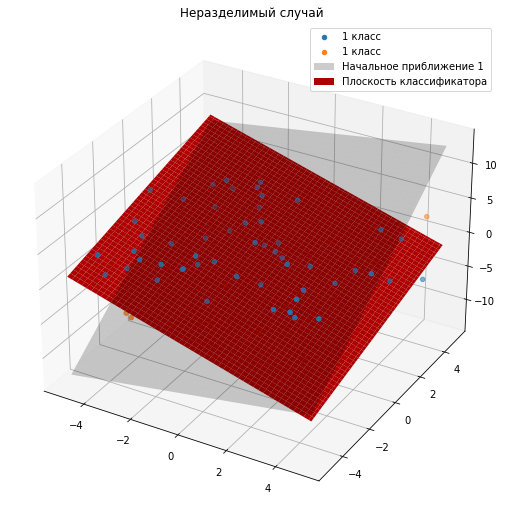

In [200]:
plane[0] *= -1
classifier = NewtonRaphson()
classifier.fit(X, y, seed=np.array([0] + list(plane)))

fig = plt.figure(figsize=(16, 9))
ax = fig.gca(projection='3d')
ax.scatter(X[y == 1, 1], X[y == 1, 2], X[y == 1, 3], label='1 класс')
ax.scatter(X[y == -1, 1], X[y == -1, 2], X[y == -1, 3], label='1 класс')

xgrid, ygrid = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
zgrid = (xgrid * plane[0] + ygrid * plane[1]) / plane[2]

params = classifier.params
classifier_zgrid = (xgrid * params[1] + ygrid * params[2]) / params[3]

surf = ax.plot_surface(xgrid, ygrid, zgrid, alpha=0.2, label='Начальное приближение 1', color='black')
surf._facecolors2d=surf._facecolors3d
surf._edgecolors2d=surf._edgecolors3d

surf = ax.plot_surface(xgrid, ygrid, classifier_zgrid, label='Плоскость классификатора', color='r')
surf._facecolors2d=surf._facecolors3d
surf._edgecolors2d=surf._edgecolors3d
plt.legend()
plt.title('Неразделимый случай')
plt.show()

**Вывод:** алгоритм работает, прекрасно разделяя классы между собой, если они разделимы. В обеих случаях если выборки линейно разделимы, то начальное приближение большой роли не играет, но если неразделимы, то ответы могут меняться в зависимости от приближения

## Посмотрим на скорость сходимости алгоритмов

In [201]:
def train_and_get_iter_cnt(X, y, epsillon, **kwargs):
    # для того, чтобы приближения были одинаковы каждый раз
    np.random.seed(seed=42)
    classifier = NewtonRaphson()
    classifier.fit(X, y, max_iter=float('inf'), threshold=epsillon, **kwargs)
    return classifier.cur_iter

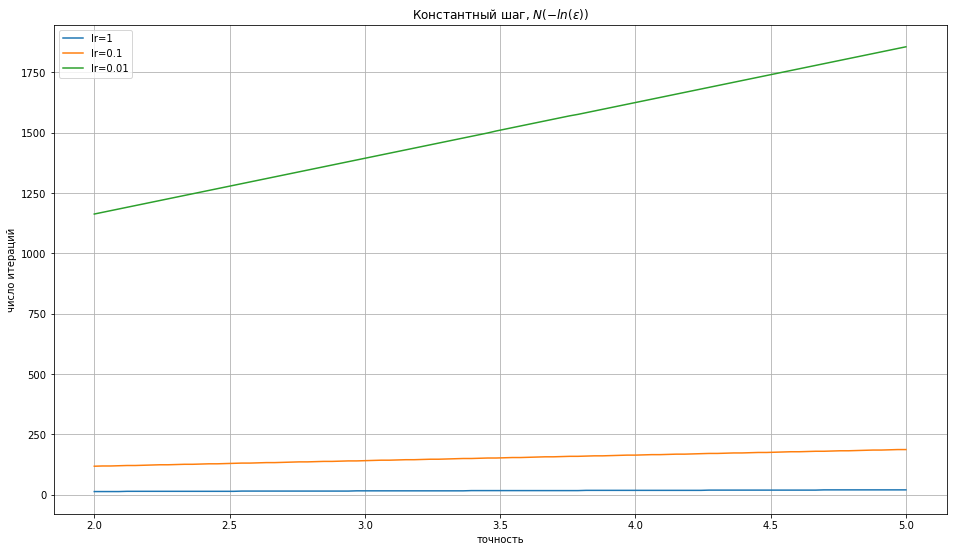

In [210]:
plt.figure(figsize=(16, 9))
X, y, plane = generate_data()
epsillon_grid = 10 ** -np.linspace(2, 5, 100)

lr_filler = lambda epsillon: train_and_get_iter_cnt(X, y, epsillon, lr=1)
iters1 = [lr_filler(eps) for eps in epsillon_grid]
plt.plot(-np.log(epsillon_grid) / np.log(10), iters1, label='lr=1')

lr_filler = lambda epsillon: train_and_get_iter_cnt(X, y, epsillon, lr=0.1)
iters01 = [lr_filler(eps) for eps in epsillon_grid]
plt.plot(-np.log(epsillon_grid) / np.log(10), iters01, label='lr=0.1')

lr_filler = lambda epsillon: train_and_get_iter_cnt(X, y, epsillon, lr=0.01)
iters001 = [lr_filler(eps) for eps in epsillon_grid]
plt.plot(-np.log(epsillon_grid) / np.log(10), iters001, label='lr=0.01')
plt.grid()
plt.title('Константный шаг, $N(-ln(\epsilon))$')
plt.legend()
plt.xlabel('точность')
plt.ylabel('число итераций')
plt.show()

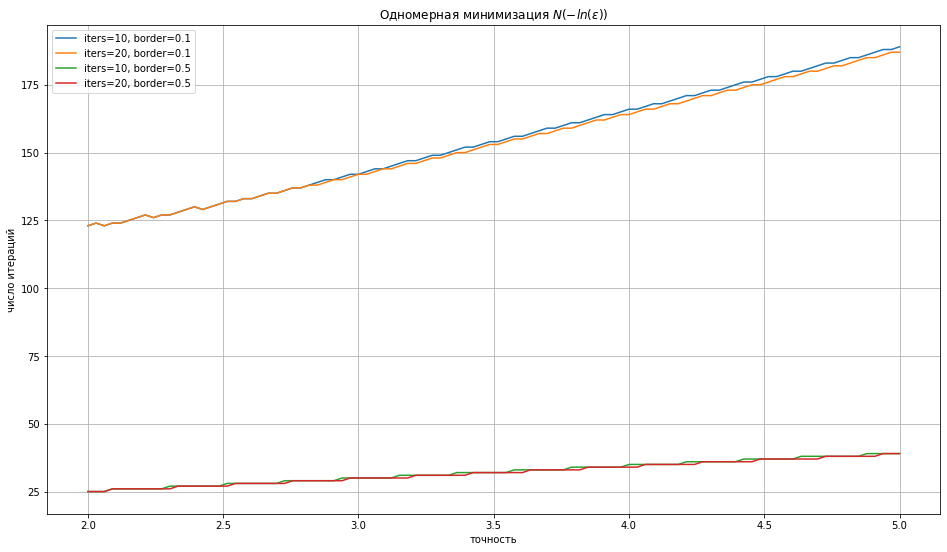

In [211]:
plt.figure(figsize=(16, 9))
lr_filler = lambda epsillon: train_and_get_iter_cnt(X, y, epsillon, use_one_side_minimization=True)
iters = [lr_filler(eps) for eps in epsillon_grid]
plt.plot(-np.log(epsillon_grid) / np.log(10), iters, label=r'iters=10, border=0.1')
lr_filler = lambda epsillon: train_and_get_iter_cnt(X, y, epsillon, use_one_side_minimization=True,
                                                    top_fastest_one_side_max_steps=20)
iters = [lr_filler(eps) for eps in epsillon_grid]
plt.plot(-np.log(epsillon_grid) / np.log(10), iters, label=r'iters=20, border=0.1')
lr_filler = lambda epsillon: train_and_get_iter_cnt(X, y, epsillon, use_one_side_minimization=True,
                                                    top_fastest_one_side_max_steps=10, top_fastest_one_side_border=0.5)
iters = [lr_filler(eps) for eps in epsillon_grid]
plt.plot(-np.log(epsillon_grid) / np.log(10), iters, label=r'iters=10, border=0.5')
lr_filler = lambda epsillon: train_and_get_iter_cnt(X, y, epsillon, use_one_side_minimization=True,
                                                    top_fastest_one_side_max_steps=20, top_fastest_one_side_border=0.5)
iters = [lr_filler(eps) for eps in epsillon_grid]
plt.plot(-np.log(epsillon_grid) / np.log(10), iters, label=r'iters=20, border=0.5')
plt.grid()
plt.title('Одномерная минимизация $N(-ln(\epsilon))$')
plt.xlabel('точность')
plt.ylabel('число итераций')
plt.legend()
plt.show()

**Вывод:** видим, что в случае с нашей задачей увеличение learning rate (до рассмотренного значения) приводит к увеличению скорости сходимости метода. Метод одномерной минимизации работает заметно лучше метода с аналогичным lr.

## LDA

In [359]:
# генерируем разделимую выборку из нормального распределения
X = sps.norm().rvs((100, 2))
y = (X[:, 1] > 0).astype('int')
y[y == 0] = -1

In [360]:
def solve_LDA(X, y):
    first_class = X[y==1] 
    second_class = X[y!=1]
    sigma = np.cov(X.T)
    w = np.linalg.inv(sigma) @ (second_class.mean(0) - first_class.mean(0))
    c = (w / 2 * (first_class.mean(0) + second_class.mean(0))).sum()
    return w, c

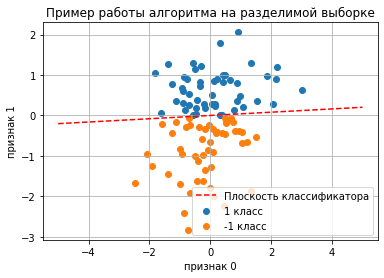

In [361]:
w, c = solve_LDA(X, y)

preds = X @ w
preds = (preds > c).astype('int')
preds[preds == 0] = -1

grid = np.linspace(-5, 5, 100)
positive_mask = (y == 1)

plt.scatter(X[positive_mask, 0], X[positive_mask, 1], label='1 класс')
plt.scatter(X[~positive_mask, 0], X[~positive_mask, 1], label='-1 класс')
plt.plot(grid, -w[0] / w[1] * grid, label='Плоскость классификатора',
         c='r', ls='dashed')
plt.legend()
plt.xlabel('признак 0')
plt.ylabel('признак 1')
plt.title("Пример работы алгоритма на разделимой выборке")
plt.grid()

**Вывод:** Алгоритм работает, притом несильно хуже линейной регрессии или метода Ньютона-Рафсона (наш метод неправильно классифицирует всего лишь несколько точек). Это прекрасный результат, особенно учитывая, что он "одношаговый"

## Q-fold

Буду использовать StratifiedKFold, чтобы внутри полученный fold'ов сохранялся баланс классов, это поможет сделать результаты более репрезентативными, q = 5

In [362]:
train_accs = []
val_accs = []
skf = StratifiedKFold(shuffle=True)
for train_index, test_index in skf.split(X, y):
    X_train = X[train_index]
    y_train = y[train_index]
    
    X_test = X[test_index]
    y_test = y[test_index]
    
    w, c = solve_LDA(X_train, y_train)
    preds = X_train @ w
    preds = (preds < c).astype('int')
    preds[preds == 0] = -1
    train_accs.append(accuracy_score(y_train, preds))
    
    preds = X_test @ w
    preds = (preds < c).astype('int')
    preds[preds == 0] = -1
    val_accs.append(accuracy_score(y_test, preds))
    
print('Точность при обучении')
print(train_accs)

print('Точность при валидации')
print(val_accs)

Точность при обучении
[0.975, 0.9875, 0.975, 0.975, 0.9625]
Точность при валидации
[1.0, 1.0, 0.9, 0.9, 0.95]


**Вывод:** Как мы видим, алгоритм, действительно, прекрасно справляется задачей классификации в разделимом случае. Притом точность при обучении и при валидации практически не отличается, это хорошо и показывает, что наша модель улавливает общие закономерности в данных, а не переобучается под train. (хотя тут в виду специфики нормального распределения и большого размера выборки (100) достаточно сложно лажать на валидации, тк она по природе совпадает с обучающей выборкой)

## Решении задачи Titanic

Попробую решить одну из самых известных задач бинарной классификации (признаков 11, выкину имя, тк моя задача - показать работоспособность Логистической регрессии, а не нахождение родственников среди пассажиров). Нужно предсказать выживет человек или умрет

In [373]:
data = pd.read_csv('./data.csv', index_col='PassengerId').drop(columns=['Name'])

### Заполним пропуски или выкинем данные

In [375]:
data.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

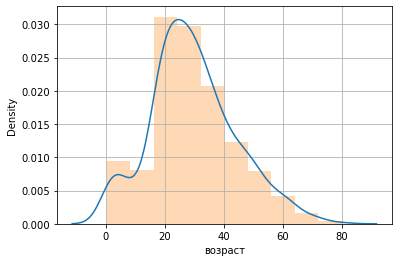

In [412]:
sns.kdeplot(data['Age'])
_, borders, _ = plt.hist(data['Age'], alpha=0.3, density=True)
plt.xlabel('возраст')
plt.grid()
plt.show()

Видим, что у нас есть основная группа по возрасту. Возраст - хороший признак, но я бы попробовал разбить всех пассажиров по bin'ам и использовать этот признак как категориальный

In [414]:
for idx, (left_border, right_border) in enumerate(zip(borders[:-1], borders[1:])):
    data['Age bin {}'.format(idx)] = data['Age'].apply(lambda x: x > left_border and x < right_border).astype('int')

In [419]:
data['Age missing'] = data['Age'].isna().astype('int')

In [420]:
data = data.drop(columns=['Age'])

Теперь с возрастом все норм

In [377]:
data['Cabin'].value_counts()

C23 C25 C27    4
B96 B98        4
G6             4
F2             3
C22 C26        3
              ..
D49            1
B3             1
B94            1
E49            1
C128           1
Name: Cabin, Length: 147, dtype: int64

По признаку Cabin мы вряд ли чем-то научимся, тк он есть лишь у ~23% людей. Попробую Cabin перегнать в более общий формат, взяв букву (наверное, это номер отсека) и выкинув цифры. Для пропущенных Cabin'ов создам новое значение признака, которого нигде в данных больше не было

In [389]:
data.loc[~data['Cabin'].isna(), 'Cabin'] = data[~data['Cabin'].isna()]['Cabin'].apply(lambda x: x[0])

In [392]:
data['Cabin'] = data['Cabin'].fillna('<UNK>')

In [393]:
data['Cabin'].value_counts()

<UNK>    687
C         59
B         47
D         33
E         32
A         15
F         13
G          4
T          1
Name: Cabin, dtype: int64

Отлично, теперь столбец стал информативен

Выкинем двух пассажиров с пропущенным Embarked. Даже если мы верно восстановим значение признака, то нам от этого сильно лучше с точки зрения качества не станет, учитвая наш размер выборки

In [425]:
data = data.dropna()

Так как мы работает с логистической регрессей, то нам надо зашифровать категориальные признаки в числа. На большинстве признаков нельзя задать какой-то поряд сравнения значений (а если можно, то вряд ли он в нашей задаче даст хотя бы малый эффект), потому будем признаки encode'ить при помощи One Hot Encoder'а. (Жаль нельзя использовать деревья, они для задача с категориальными фичами лучше годятся :( )

In [431]:
y = data['Survived']
data = data.drop(columns=['Survived'])

In [433]:
data['Sex'] = (data['Sex'] == 'male').astype('int')

In [435]:
data['Ticket'].value_countscounts()

347082      7
1601        7
CA. 2343    7
CA 2144     6
3101295     6
           ..
113807      1
28665       1
112053      1
17764       1
349242      1
Name: Ticket, Length: 680, dtype: int64

Признак билет не информативен - выкинем

In [443]:
data = data.drop(columns=['Ticket'])

In [452]:
dummies = pd.get_dummies(data['Embarked'])
data[dummies.columns] = dummies
data = data.drop(columns='Embarked')

In [453]:
dummies = pd.get_dummies(data['Cabin'])
data[dummies.columns] = dummies
data = data.drop(columns='Cabin')

Больше категориальных признаков нету, обучим классификатор

In [484]:
train_accs = []
val_accs = []
skf = StratifiedKFold(shuffle=True)
X = data.to_numpy() 
for train_index, test_index in skf.split(X, y):
    X_train = X[train_index]
    y_train = y.iloc[train_index]
    
    X_test = X[test_index]
    y_test = y.iloc[test_index]
    
    classifier = LogisticRegression(max_iter=1000)
    classifier.fit(X_train, y_train)
    
    preds = classifier.predict(X_train)
    train_accs.append(accuracy_score(y_train, preds))
    
    preds = classifier.predict(X_test)
    val_accs.append(accuracy_score(y_test, preds))
    
print('Точность при обучении')
print(train_accs)
print('Средняя точность при обучении {}'.format(sum(train_accs) / len(train_accs)))

print('Точность при валидации')
print(val_accs)
print('Средняя точность при валидации {}'.format(sum(val_accs) / len(val_accs)))

Точность при обучении
[0.8185654008438819, 0.8045007032348804, 0.8227848101265823, 0.829817158931083, 0.8160112359550562]
Средняя точность при обучении 0.8183358618182967
Точность при валидации
[0.8202247191011236, 0.8258426966292135, 0.7752808988764045, 0.7640449438202247, 0.8248587570621468]
Средняя точность при валидации 0.8020504030978227


**Вывод:** Видим, что на валидации ошибка несколько больше, но отличие точностей в пределах разумного, значит модель не переобучилась и значит задача решена достаточно неплохо (и в случае наличия отложенных выборок моя модель может быть использоваана для работы на них)